## Import Packages

In [72]:
from google.colab import drive
drive.mount('/content/drive')


import os
import time
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn import metrics
from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.utils import to_categorical
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm, Normalize
from pprint import pprint

from PIL import Image
from osgeo import gdal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration


In [73]:
#### Download site data

# Note: if gdown is not working, please manually download the file and extract it to you Google Drive
# Example Data
# https://drive.google.com/file/d/12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh/view?usp=sharing

# !gdown --id '12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh'

example_bands = "/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/demo_site.csv" # Replace this with the path to demo_site.csv on your Drive

In [74]:
#### Dataset Structure 1 (Bands)

print("This is an example input data structure your competition classifier must be able to work with:\n")
df_bands = pd.read_csv(example_bands)
df_classes = df_bands.iloc[:, [12]]
df_classes = df_classes.astype('int64')
df_bands.drop(df_bands.columns[12], axis=1, inplace=True)
df_bands = df_bands.astype('float64')
print(df_bands.info())

print("\nRecall: These columns correspond to the following band names:")
df_bands.head(10)

This is an example input data structure your competition classifier must be able to work with:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B01     float64
 1   B02     float64
 2   B03     float64
 3   B04     float64
 4   B05     float64
 5   B06     float64
 6   B07     float64
 7   B08     float64
 8   B09     float64
 9   B11     float64
 10  B12     float64
 11  B8A     float64
dtypes: float64(12)
memory usage: 480.7 MB
None

Recall: These columns correspond to the following band names:


,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.0269,0.0323,0.0486,0.0336,0.0826,0.2044,0.2381,0.2459,0.2557,0.1522,0.0807,0.2563
1,0.0261,0.0310,0.0492,0.0307,0.0814,0.2132,0.2465,0.2552,0.2593,0.1454,0.0743,0.2621
2,0.0260,0.0285,0.0438,0.0239,0.0693,0.1920,0.2221,0.2269,0.2242,0.1182,0.0574,0.2336
3,0.0272,0.0295,0.0406,0.0234,0.0581,0.1477,0.1752,0.1783,0.1839,0.0773,0.0370,0.1854
4,0.0248,0.0293,0.0451,0.0307,0.0769,0.2037,0.2391,0.2461,0.2592,0.1472,0.0764,0.2564
5,0.0266,0.0302,0.0447,0.0326,0.0742,0.1853,0.2178,0.2239,0.2396,0.1453,0.0780,0.2360
6,0.0260,0.0320,0.0497,0.0343,0.0848,0.2318,0.2741,0.2820,0.2952,0.1718,0.0913,0.2951
7,0.0243,0.0270,0.0468,0.0239,0.0805,0.2597,0.3054,0.3131,0.3260,0.1593,0.0756,0.3266
8,0.0247,0.0278,0.0404,0.0224,0.0613,0.1688,0.1994,0.2028,0.2159,0.1027,0.0500,0.2102
9,0.0248,0.0286,0.0410,0.0239,0.0615,0.1572,0.1831,0.1850,0.1946,0.0972,0.0502,0.1937


In [75]:
#### Dataset structure 2 (Classes)

print("These are the corresponding the cover classes for the above inputs which can range from 0-19.\n \
 Note that the area we are testing here does not necessarily have all 19 land cover types:\n")
print(df_classes.info())

print("\nHere are the unique land cover types included in this scene:")
print(df_classes.land_cover.unique())

print('\nAn example of what this DF looks like:')
df_classes.head(10)

These are the corresponding the cover classes for the above inputs which can range from 0-19.
  Note that the area we are testing here does not necessarily have all 19 land cover types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 1 columns):
 #   Column      Dtype
---  ------      -----
 0   land_cover  int64
dtypes: int64(1)
memory usage: 40.1 MB
None

Here are the unique land cover types included in this scene:
[ 8  1  6 14  5 18 17 10 16 15  2 12]

An example of what this DF looks like:


,land_cover
0,8
1,1
2,1
3,1
4,8
5,8
6,8
7,6
8,6
9,6


In [76]:
#### Example plotting functions to display S2 data in Python

def show_band_matrix():
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(75,25))
    plt.suptitle("Sentinel-2 Bands", fontsize=60)
    band_count = 1
    df = df_bands
    for i,ax_row in enumerate(axes):
        for j, ax_col in enumerate(ax_row):
            if i == 1 and j == 3: # Special case for 8a band
                title = 'B8A'
                imband = np.asarray(df[title]).reshape(2500, 2100).T
                band_count += 1
            else: # Individual bands
                title = 'B' + str(band_count).zfill(2)
                imband = np.asarray(df[title]).reshape(2500, 2100).T
                band_count += 1
            
            axes[i][j].set_title(title)
            axes[i][j].imshow(imband, aspect='auto')
            axes[i][j].set_axis_off()

def show_land_cover():
    df = df_classes
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(40,15))
    ax.set_title("NRCan - 2015 Land Cover of Canada")
    cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
    im = ax.imshow(np.asarray(df.land_cover).reshape(2500, 2100).T, cmap=cmap, aspect='auto')
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax)
    
    ax2.grid(linestyle='--')
    dp = sns.distplot(df.land_cover, hist=False, kde_kws=dict(linewidth=8))
    l1 = ax2.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax2.fill_between(x1,y1, color="#5471ab", alpha=0.3)
    ax2.set_xlabel("Land Cover Type")
    ax2.set_title("Land Cover Density")

show_band_matrix()
show_land_cover()

Output hidden; open in https://colab.research.google.com to view.

In [77]:
df_classes

,land_cover
0,8
1,1
2,1
3,1
4,8
...,...
5249995,18
5249996,18
5249997,18
5249998,18


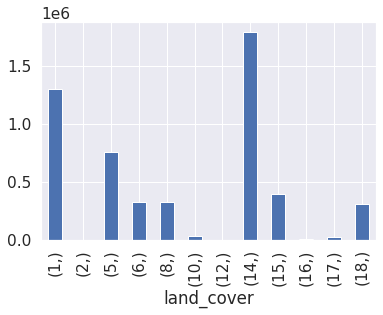

In [78]:
df_classes.value_counts().sort_index().plot.bar()

In [79]:
#### Create X and y variables for data splitting
y = df_classes
X = df_bands

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

pickle_path = r'/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/scaler_CNN_Classifier_traintestvalid_classweight_onFraserDataset.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(scaler, f)

#### CNN Analysis

(4200000, 12) (1050000, 12) (4200000, 1) (1050000, 1)


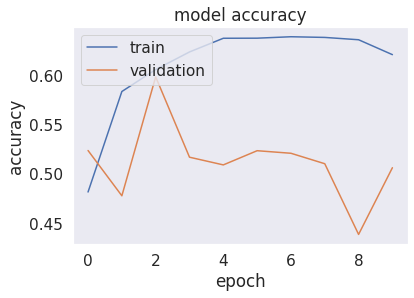

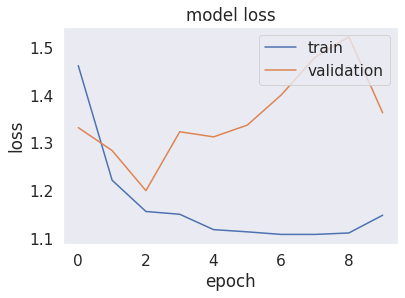

Test loss:1.36
Test accuracy:50.65%
Balanced Accuracy: 25.85%


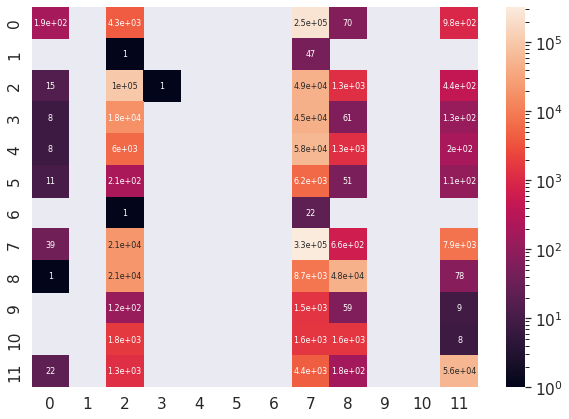

Total Elapsed time = 4.0 min
INFO:tensorflow:Assets written to: ram://1d6bc5ed-29eb-4c9f-acad-9bab9f931d9f/assets


In [ ]:
# fit and evaluate a CNN_model: without weight balance
def evaluate_model(dropout=0.5, recurrent_dropout = 0.5, n_features = 12, n_output = 19):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling1D(pool_size=1))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_output, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
    return model
       
    
# run an experiment
def run_experiment(trainX, trainy, repeats=1, epochs=100, batch_size=100, verbose=0):

    i=0
    while i < repeats:
      i += 1

      #### Data splitting
      X_train, X_test, y_train, y_test = train_test_split(trainX, trainy,
                                                          test_size=0.2, 
                                                          random_state=42)
      print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      # fit network   
      model = evaluate_model(dropout=0.5, recurrent_dropout = 0.5,
                             n_features = X_train.shape[1],
                             n_output = 19)
      X_train = X_train.reshape(-1, 1, X_train.shape[1])
      X_test = X_test.reshape(-1, 1, X_test.shape[1])
      model_res = model.fit(X_train,
                            y_train, epochs=epochs, batch_size=batch_size,
                          validation_data=(X_test, y_test), verbose=verbose,
                          shuffle=True)

      # Plot accuracy and loss
      plt.plot(model_res.history['accuracy'])
      plt.plot(model_res.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.grid()
      plt.show()

      plt.plot(model_res.history['loss'])
      plt.plot(model_res.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper right')
      plt.grid()
      plt.show()

      # Print the score
      score = model.evaluate(X_test, y_test, verbose = 0) 

      print(f'Test loss:{score[0]:0.2f}') 
      print(f'Test accuracy:{score[1]*100:0.2f}%')

      y_pred = np.argmax(model.predict(X_test), axis =1)

      print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:0.2f}%')

      # Plot a confusion matrix
      results = confusion_matrix(y_test, y_pred)
      df_cm = pd.DataFrame(results, range(12), range(12))
      plt.figure(figsize=(10,7))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, norm=LogNorm()) # font size
      plt.show()

    return model

st = time.time()
model = run_experiment(X, y, repeats=1, epochs=10, batch_size=10000, verbose=0)
print(model)
print( f'Total Elapsed time = {(time.time() - st)/60 :.1f} min')

# Save the model as pickle file

pickle_path = r'/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/model_CNN_Classifier_traintestvalid_noclassweight_onFraserDataset.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

Results with weight balance, missing class have classweights of mean of existing class_weights
(4200000, 12) (1050000, 12) (4200000, 1) (1050000, 1)


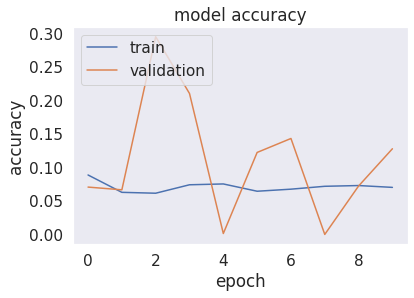

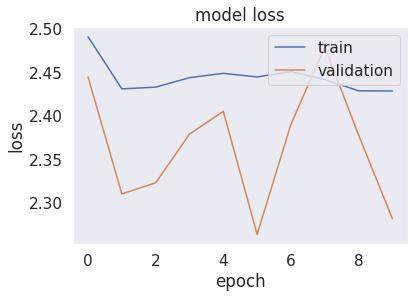

Test loss:2.28
Test accuracy:12.78%
Balanced Accuracy: 15.99%


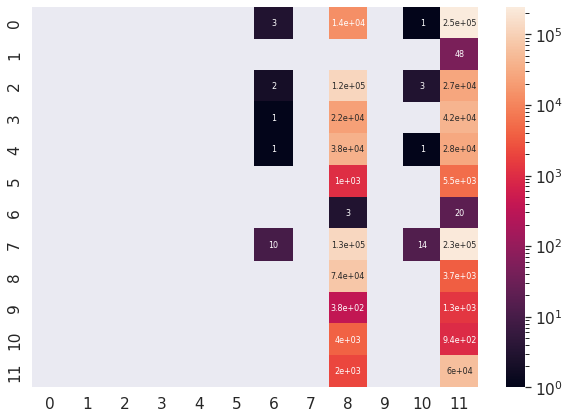

Total Elapsed time = 5.0 min
INFO:tensorflow:Assets written to: ram://844c6234-0592-4d82-a213-3397e7cd1d33/assets


In [ ]:
# fit and evaluate a CNN_model: weight balance
# missing classweight = mean(existing classweights)
def evaluate_model(dropout=0.5, recurrent_dropout = 0.5, n_features = 12, n_output = 19):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling1D(pool_size=1))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_output, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
    return model
       
    
# run an experiment
def run_experiment(trainX, trainy, repeats=1, epochs=100, batch_size=100, verbose=0):

    i=0
    while i < repeats:
      i += 1

      #### Data splitting
      X_train, X_test, y_train, y_test = train_test_split(trainX, trainy,
                                                          test_size=0.2, 
                                                          random_state=42)
      print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      # fit network   
      model = evaluate_model(dropout=0.5, recurrent_dropout = 0.5,
                             n_features = X_train.shape[1],
                             n_output = 19)
      X_train = X_train.reshape(-1, 1, X_train.shape[1])
      X_test = X_test.reshape(-1, 1, X_test.shape[1])

      class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.values.reshape(-1))
      weights_dict = {l:c for l,c in zip(np.unique(y_train), class_weights)}
      for i in np.arange(max(np.unique(y_train))):
        if i not in weights_dict: weights_dict[i] = np.mean(class_weights)

      weighted_history  = model.fit(X_train, y_train, 
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_test, y_test), verbose=verbose,
                            class_weight=weights_dict, 
                            shuffle=True)

      # Plot accuracy and loss
      plt.plot(weighted_history.history['accuracy'])
      plt.plot(weighted_history.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.grid()
      plt.show()

      plt.plot(weighted_history.history['loss'])
      plt.plot(weighted_history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper right')
      plt.grid()
      plt.show()

      # Print the score
      score = model.evaluate(X_test, y_test, verbose = 0) 

      print(f'Test loss:{score[0]:0.2f}') 
      print(f'Test accuracy:{score[1]*100:0.2f}%')

      y_pred = np.argmax(model.predict(X_test), axis =1)

      print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:0.2f}%')

      # Plot a confusion matrix
      results = confusion_matrix(y_test, y_pred)
      df_cm = pd.DataFrame(results, range(12), range(12))
      plt.figure(figsize=(10,7))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, norm=LogNorm()) # font size
      plt.show()

    return model

st = time.time()
print('Results with weight balance, missing class have classweights of mean of existing class_weights')
model = run_experiment(X, y, repeats=1, epochs=10, batch_size=10000, verbose=0)
print(model)
print( f'Total Elapsed time = {(time.time() - st)/60 :.1f} min')

# Save the model as pickle file

pickle_path = r'/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/model_CNN_Classifier_traintestvalid_classweightmeanval_onFraserDataset.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

Results with weight balance, missing class have classweights of zero
(4200000, 12) (1050000, 12) (4200000, 1) (1050000, 1)


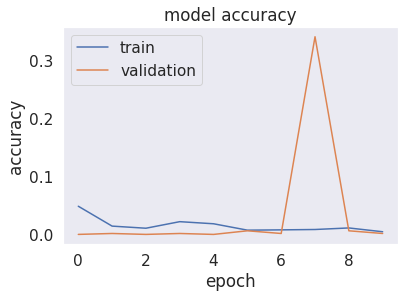

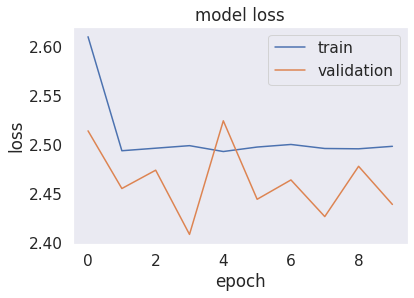

Test loss:2.44
Test accuracy:0.16%
Balanced Accuracy: 8.33%


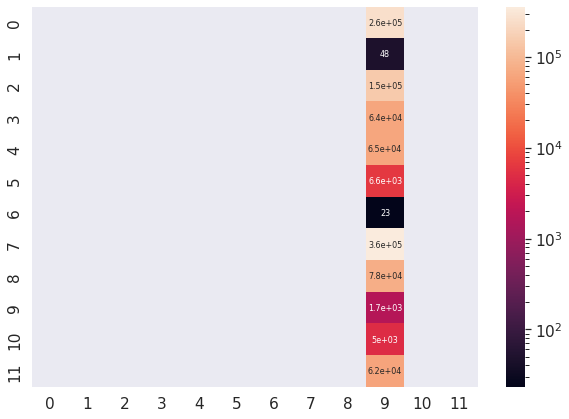

Total Elapsed time = 4.7 min
INFO:tensorflow:Assets written to: ram://910d6770-84d9-4d60-aea6-7be793a220aa/assets


In [ ]:
# fit and evaluate a CNN_model: weight balance
# missing classweight = zero
def evaluate_model(dropout=0.5, recurrent_dropout = 0.5, n_features = 12, n_output = 19):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling1D(pool_size=1))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_output, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
    return model
       
    
# run an experiment
def run_experiment(trainX, trainy, repeats=1, epochs=100, batch_size=100, verbose=0):

    i=0
    while i < repeats:
      i += 1

      #### Data splitting
      X_train, X_test, y_train, y_test = train_test_split(trainX, trainy,
                                                          test_size=0.2, 
                                                          random_state=42)
      print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      # fit network   
      model = evaluate_model(dropout=0.5, recurrent_dropout = 0.5,
                             n_features = X_train.shape[1],
                             n_output = 19)
      X_train = X_train.reshape(-1, 1, X_train.shape[1])
      X_test = X_test.reshape(-1, 1, X_test.shape[1])

      class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.values.reshape(-1))
      weights_dict = {l:c for l,c in zip(np.unique(y_train), class_weights)}
      for i in np.arange(max(np.unique(y_train))):
        if i not in weights_dict: weights_dict[i] = 0

      weighted_history  = model.fit(X_train, y_train, 
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_test, y_test), verbose=verbose,
                            class_weight=weights_dict, 
                            shuffle=True)

      # Plot accuracy and loss
      plt.plot(weighted_history.history['accuracy'])
      plt.plot(weighted_history.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.grid()
      plt.show()

      plt.plot(weighted_history.history['loss'])
      plt.plot(weighted_history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper right')
      plt.grid()
      plt.show()

      # Print the score
      score = model.evaluate(X_test, y_test, verbose = 0) 

      print(f'Test loss:{score[0]:0.2f}') 
      print(f'Test accuracy:{score[1]*100:0.2f}%')

      y_pred = np.argmax(model.predict(X_test), axis =1)

      print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:0.2f}%')

      # Plot a confusion matrix
      results = confusion_matrix(y_test, y_pred)
      df_cm = pd.DataFrame(results, range(12), range(12))
      plt.figure(figsize=(10,7))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, norm=LogNorm()) # font size
      plt.show()

    return model

st = time.time()
print('Results with weight balance, missing class have classweights of zero')
model = run_experiment(X, y, repeats=1, epochs=10, batch_size=10000, verbose=0)
print(model)
print( f'Total Elapsed time = {(time.time() - st)/60 :.1f} min')

# Save the model as pickle file

pickle_path = r'/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/model_CNN_Classifier_traintestvalid_classweightzeroval_onFraserDataset.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

Results with weight balance, missing class have classweights of one
(4200000, 12) (1050000, 12) (4200000, 1) (1050000, 1)
Weights_dict
{0: 1,
 1: 0.33767812521104884,
 2: 1933.7016574585634,
 3: 1,
 4: 1,
 5: 0.5795392828284166,
 6: 1.3671180760352013,
 7: 1,
 8: 1.333465409907267,
 9: 1,
 10: 13.364389629233647,
 11: 1,
 12: 4794.520547945205,
 13: 1,
 14: 0.2449038997097539,
 15: 1.123718158643319,
 16: 51.36483710008805,
 17: 17.598551890587288,
 18: 1.4149875481095766}


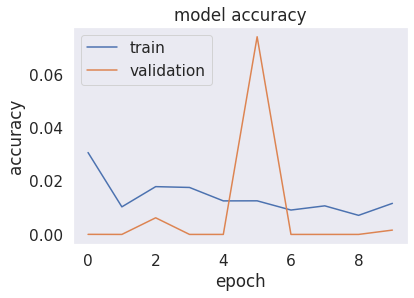

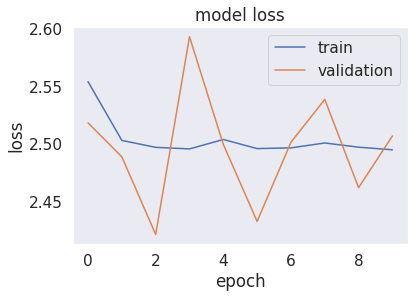

Test loss:2.51
Test accuracy:0.16%
Balanced Accuracy: 8.33%


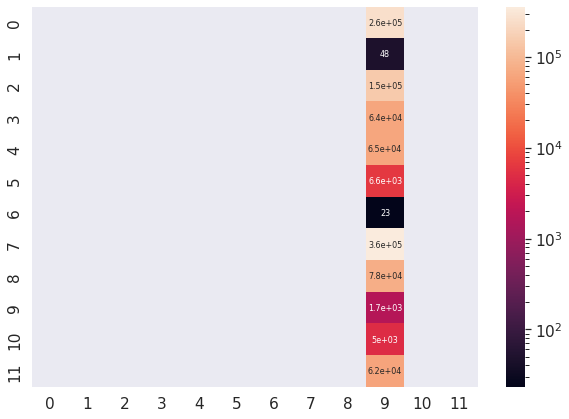

Total Elapsed time = 5.3 min
INFO:tensorflow:Assets written to: ram://c47b76ac-0e36-4fe5-b1d9-03fa7b73c2d2/assets


In [80]:
# fit and evaluate a CNN_model: weight balance
# missing classweight = 1.0
def evaluate_model(dropout=0.5, recurrent_dropout = 0.5, n_features = 12, n_output = 19):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling1D(pool_size=1))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_output, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
    return model
       
    
# run an experiment
def run_experiment(trainX, trainy, repeats=1, epochs=100, batch_size=100, verbose=0):

    i=0
    while i < repeats:
      i += 1

      #### Data splitting
      X_train, X_test, y_train, y_test = train_test_split(trainX, trainy,
                                                          test_size=0.2, 
                                                          random_state=42)
      print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      # fit network   
      model = evaluate_model(dropout=0.5, recurrent_dropout = 0.5,
                             n_features = X_train.shape[1],
                             n_output = 19)
      X_train = X_train.reshape(-1, 1, X_train.shape[1])
      X_test = X_test.reshape(-1, 1, X_test.shape[1])

      class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.values.reshape(-1))
      weights_dict = {l:c for l,c in zip(np.unique(y_train), class_weights)}
      for i in np.arange(max(np.unique(y_train))):
        if i not in weights_dict: 
          weights_dict[i] = 1
      
      print('Weights_dict')
      pprint(weights_dict)

      weighted_history  = model.fit(X_train, y_train, 
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_test, y_test), verbose=verbose,
                            class_weight=weights_dict, 
                            shuffle=True)

      # Plot accuracy and loss
      plt.plot(weighted_history.history['accuracy'])
      plt.plot(weighted_history.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.grid()
      plt.show()

      plt.plot(weighted_history.history['loss'])
      plt.plot(weighted_history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper right')
      plt.grid()
      plt.show()

      # Print the score
      score = model.evaluate(X_test, y_test, verbose = 0) 

      print(f'Test loss:{score[0]:0.2f}') 
      print(f'Test accuracy:{score[1]*100:0.2f}%')

      y_pred = np.argmax(model.predict(X_test), axis =1)

      print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:0.2f}%')

      # Plot a confusion matrix
      results = confusion_matrix(y_test, y_pred)
      df_cm = pd.DataFrame(results, range(12), range(12))
      plt.figure(figsize=(10,7))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, norm=LogNorm()) # font size
      plt.show()

    return model

st = time.time()
print('Results with weight balance, missing class have classweights of one')
model = run_experiment(X, y, repeats=1, epochs=10, batch_size=10000, verbose=0)
print(model)
print( f'Total Elapsed time = {(time.time() - st)/60 :.1f} min')

# Save the model as pickle file

pickle_path = r'/content/drive/MyDrive/Colab Notebooks/AISC/SentinelAI/model_CNN_Classifier_traintestvalid_classweightoneval_onFraserDataset.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)